# Statistical Methods in AI (CSE/ECE 471) - Spring-2020
#  Assignment-2 / **Q3** / Topic: Linear Regression - AirFoil Data
# Submitted By: VENUGOPAL REDDY MEKA
# Roll No: 2019900065

In [2]:
# Load the required imports
import matplotlib.pyplot as plt
import seaborn as sns

# use matplotlib inline for Jupyter notebook
%matplotlib inline

In [2]:
import pandas as pd

In [5]:
"""
Statistical Methods in AI (CSE/ECE 471)
Spring-2020
Assignment-2
Q3
Topic: Linear Regression
Submitted By: VENUGOPAL REDDY MEKA
Roll No: 2019900065
"""

import pandas as pd
import sys
import numpy as np
import logging.config
import matplotlib.pyplot as plt

# Configuration for logging
logging_config = {
    'version': 1,
    'disable_existing_loggers': False,
    'formatters': {
        'standard': {
            'format': '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
            'datefmt': "%Y-%m-%d %H:%M:%S"
        }
    },
    'handlers': {
        'console': {
            'level': 'DEBUG',
            'formatter': 'standard',
            'class': 'logging.StreamHandler',
            'stream': 'ext://sys.stdout',
        }
    },
    'loggers': {
        '': {
            'handlers': ['console'],
            'level': 'INFO'
        },
    }
}
logging.config.dictConfig(logging_config)


class AirFoil:
    """
    DecisionTreeNode class.
    Uses recursion to create the decision tree nodes
    """

    def __init__(self, show_plots=True):
        """

        """
        self.show_plots = show_plots
        self.logger = logging.getLogger(__name__)
        self.headers = ['Frequency', 'Angle', 'Chord_Length', 'Velocity', 'Displacement_Thickness', 'Sound_Pressure']
        self._alpha = 0
        self._iterations = 0
        self._possible_lambdas = list()
        self._cross_validation_times = 20
        self.cost_func = self.squared_error_cost
        self.mew_x = None
        self.std_x = None
        self.mew_y = None
        self.std_y = None
        self.theta = None

    @property
    def alpha(self):
        return self._alpha

    @alpha.setter
    def alpha(self, alpha):
        self._alpha = alpha

    @property
    def iterations(self):
        return self._iterations

    @iterations.setter
    def iterations(self, iterations):
        self._iterations = iterations

    @property
    def possible_lambdas(self):
        return self._possible_lambdas

    @possible_lambdas.setter
    def possible_lambdas(self, possible_lambdas):
        self._possible_lambdas = possible_lambdas

    @property
    def cross_validation_times(self):
        return self._cross_validation_times

    @cross_validation_times.setter
    def cross_validation_times(self, cross_validation_times):
        self._cross_validation_times = cross_validation_times

    def train(self, train_csv, alpha=0.001, iterations=6000, possible_lambdas=[0, 0.3, 1, 3]):
        try:
            if not train_csv:
                raise ValueError("Input train data csv cannot be None")

            self._alpha = alpha
            self._iterations = iterations
            self._possible_lambdas = possible_lambdas

            # load the csv file
            self.logger.info("Loading the input train data into dataframe")
            df = pd.read_csv(train_csv, header=None, names=self.headers)
            self.logger.info(df.head(5))
            self.logger.info(f"Shape of the input data {df.shape}")

            # prepare the dataset
            (x, y, col_names) = self.prepare_dataset(df)

            # normalize the dataset
            self.mew_x = []
            self.std_x = []
            M = x.shape[0]
            N = x.shape[1]
            # Normalize the input features
            for i in range(N):
                self.logger.info(f"Normalizing the input feature: {col_names[i+1]}")
                (mew_val, std_val, x[:, i]) = self.normalize(x[:, i])
                self.mew_x.append(mew_val)
                self.std_x.append(std_val)

            # Normalize the target feature
            self.logger.info(f"Normalizing the target feature: {col_names[0]}")
            (self.mew_y, self.std_y, y) = self.normalize(y)

            # Append ones vector to x, the shape of x will become (M, N+1)
            ones_vec = np.ones((M, 1), dtype=int)
            x = np.hstack((ones_vec, x))

            # Split the dataset
            (train_x, validation_x, test_x, train_y, validation_y, test_y) = \
                self.train_validation_test_split(x, y, 70, 20, 10)

            # Compute the optimum coefficients
            min_cost, self.theta, final_lambda = \
                self.compute_optimum_coefficients(train_x, validation_x, train_y, validation_y)

            self.logger.info(
                f"Final optimum coefficients: {self.theta}, cost: {min_cost} and lambda: {final_lambda}")

            train_error_cost = self.squared_error_cost(train_x, train_y, self.theta, final_lambda)
            self.logger.info(f"Cost on the train dataset: {train_error_cost}")

            validation_error_cost = self.squared_error_cost(validation_x, validation_y, self.theta, final_lambda)
            self.logger.info(f"Cost on the train dataset: {validation_error_cost}")

            test_error_cost = self.squared_error_cost(test_x, test_y, self.theta, final_lambda)
            self.logger.info(f"Cost on the test dataset: {test_error_cost}")

            self.logger.info("Prediction test on train dataset")
            rmse = self.prediction_test(train_x, train_y, self.theta, self.mew_x, self.std_x, self.mew_y, self.std_y, col_names, True, 2)
            self.logger.info(f"RMSE on the train dataset: {rmse}")
            self.logger.info("Prediction test on validation dataset")
            rmse = self.prediction_test(validation_x, validation_y, self.theta, self.mew_x, self.std_x, self.mew_y, self.std_y, col_names, True, 2)
            self.logger.info(f"RMSE on the validation dataset: {rmse}")
            self.logger.info("Prediction test on test dataset")
            rmse = self.prediction_test(test_x, test_y, self.theta, self.mew_x, self.std_x, self.mew_y, self.std_y, col_names, True, 2)
            self.logger.info(f"RMSE on the test dataset: {rmse}")

        except Exception as err:
            self.logger.error("Error occurred while updating the training data ", str(err))

    def prepare_dataset(self, df):
        """
        Prepares dataset x and y from the input dataframe, performs pre-processing and returns (x, y, col_names)
        :param df: dataframe with features and target variable
        :return: x (an ndarray) is the feature matrix of size (M X N)
                 y (an ndarray) contains actual results (of size (M X 1))
                 col_names is a python list which has the first element as the column name for y, the
                 subsequent names are the names of features present in X
        """
        self.logger.info("Preparing the dataset by extracting feature and target data")
        # Drop NaN rows
        df = df.dropna()
        self.logger.info(f"Shape of data after dropping NaN rows: {df.shape}")
        self.logger.info(df.head())

        df_features = df.drop(columns=["Sound_Pressure"], axis=1)
        df_target = df[["Sound_Pressure"]]

        y = df_target.values
        self.logger.info(f"Shape of the y dataset: {y.shape}")
        x = df_features.values
        self.logger.info(f"Shape of the x dataset: {x.shape}")
        col_names = df_target.columns.tolist() + df_features.columns.tolist()
        self.logger.info(f"Rearranged column names of the dataset: {col_names}")

        # Visualize them
        if self.show_plots:
            for i in range(x.shape[1]):
                feature = x[:, i].reshape(x.shape[0], 1)
                fig = plt.figure(figsize=(7, 6), dpi=80, facecolor='w', edgecolor='k')
                plt.plot(feature, y, 'bo', markersize=5, label=col_names[i + 1])
                plt.legend(loc='upper left')
                plt.xlabel(col_names[i + 1])
                plt.ylabel(col_names[0])

        return x, y, col_names

    def train_validation_test_split(self, x, y, train_per=70, validation_per=20, test_per=10):
        """
        Splits dataset (i.e. x, y) into 3 parts, specified by their percentages
        train: 70%
        validation: 20%
        test: 10%
        """
        self.logger.info("Splitting the data to train, validation and test datasets")
        rows = x.shape[0]
        cols = x.shape[1]

        combined = np.hstack((x, y))
        np.random.shuffle(combined)

        x = combined[:, :cols]
        y = combined[:, cols:]

        train_size = int((train_per / 100) * rows)
        validation_size = int((validation_per / 100) * rows)

        train_x = x[:train_size]
        validation_x = x[train_size:train_size + validation_size]
        test_x = x[train_size + validation_size:]

        train_y = y[:train_size]
        validation_y = y[train_size:train_size + validation_size]
        test_y = y[train_size + validation_size:]

        self.logger.info(f"X: {x.shape}")
        self.logger.info(f"X: {y.shape}")
        self.logger.info(f"train_x: {train_x.shape}")
        self.logger.info(f"train_y: {train_y.shape}")
        self.logger.info(f"validation_x: {validation_x.shape}")
        self.logger.info(f"validation_y: {validation_y.shape}")
        self.logger.info(f"test_x: {test_x.shape}")
        self.logger.info(f"test_y: {test_y.shape}")

        return train_x, validation_x, test_x, train_y, validation_y, test_y

    def compute_optimum_coefficients(self, train_x, validation_x, train_y, validation_y):
        """
        Computes optimum coefficients
        :param train_x:
        :param validation_x:
        :param train_y:
        :param validation_y:
        :return:
        """
        min_cost = sys.maxsize
        optimal_theta = None
        final_lambda = None

        for lambda_ in self.possible_lambdas:
            self.logger.info(f"Optimizing for lambda: {lambda_}")
            theta, cost = self.gradient_descent_optimize(train_x,
                                                         validation_x,
                                                         train_y,
                                                         validation_y,
                                                         lambda_)
            self.logger.info(f"Computed coefficients: {theta} and cost: {cost} for lambda: {lambda_}")

            if cost < min_cost:
                min_cost = cost
                optimal_theta = theta
                final_lambda = lambda_

        return min_cost, optimal_theta, final_lambda

    def gradient_descent_optimize(self, train_x, validation_x, train_y, validation_y, lambda_):
        """
        Performs training on train_x and train_y using the cost_func() cost function

        Starts by randomly initializing the theta vector. Multiple random initializations
        are done, 'cross_validation_times' times, and a global optimal theta is returned
        along with the global_min_cost

        Each random initialization result is tested on validation_x and validation_y
        """

        N = train_x.shape[1]
        min_cost = sys.maxsize
        optimal_theta = np.empty((N, 1))

        # Loop which runs multiple times (Each time trying a new random initialization)
        for i in range(self.cross_validation_times):
            theta = np.random.rand(N, 1)
            theta = self.gradient_descent(train_x, train_y, theta, lambda_, i==0)
            cost = self.cost_func(validation_x, validation_y, optimal_theta, lambda_)
            if cost < min_cost:
                min_cost = cost
                optimal_theta = theta

        return optimal_theta, min_cost

    def gradient_descent(self, x, y, theta, lambda_, create_new_fig):
        """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)

        Runs gradient descent algorithm for num_iters times and returns the final theta and cost
        Also plots the way cost has varied over time
        """
        M = x.shape[0]
        cost_arr = []

        for i in range(self.iterations):
            h = x @ theta
            reg_term = lambda_ * theta[1:]
            theta[0] = theta[0] - (self.alpha / M) * np.sum(h - y)
            theta[1:] = theta[1:] - (self.alpha / M) * (np.sum((h - y) * x[:, 1:], axis=0, keepdims=True).T + reg_term)
            cost_arr.append(self.cost_func(x, y, theta, lambda_))

        if create_new_fig and self.show_plots:
            fig = plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
            plt.xlabel('iterations')
            plt.ylabel('cost')
            plt.title('lambda=' + str(lambda_))

        plt.plot(cost_arr)

        return theta

    @staticmethod
    def de_normalize(mew, std, vec):
        """
        mew and std are numbers denoting the original mean and standard deviation of the vector.
        vec is of size (M X 1), i.e. it is a single feature vector
        Returns the de-normalized vector
        """
        return (vec * std) + mew

    @staticmethod
    def normalize(vec):
        """
        vec is of size (M X 1), i.e. it is a single feature vector
        Returns a normalized vector
        """
        mew = np.average(vec)
        std = np.std(vec)
        return mew, std, (vec - mew) / std

    @staticmethod
    def squared_error_cost(x, y, theta, lambda_):
        """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)
        """

        # calculate hypothesis
        h = x @ theta

        # calculate regularization term
        reg_term = np.sum(lambda_ * (theta[1:, :].reshape(theta.shape[0] - 1, 1) ** 2))

        M = x.shape[0]

        # calculate cost and return it
        cost = (1 / (2 * M)) * (np.sum((h - y) ** 2) + reg_term)
        return cost

    @staticmethod
    def sample(a, b, c, num):
        """
        a and b and c are of size (M X N)
        Returns 'num' no:of samples randomly chosen from a and b
        """
        rand_index = np.arange(a.shape[0]).reshape(a.shape[0], 1)
        np.random.shuffle(rand_index)
        rand_index = rand_index[0:num]
        return a[rand_index].reshape(num, a.shape[1]), b[rand_index].reshape(num, b.shape[1]), c[rand_index].reshape(
            num, c.shape[1])

    def predict(self, test_csv):
        """

        :param test_csv:
        :return:
        """
        # load the csv file
        self.logger.info("Loading the input train data into dataframe")
        df = pd.read_csv(test_csv, header=None, names=self.headers[:-1])
        x_test = df.values
        # normalize the dataset
        mew_x = []
        std_x = []
        M = x_test.shape[0]
        N = x_test.shape[1]
        # Normalize the input features
        for i in range(N):
            self.logger.info(f"Normalizing the input feature: {df.columns[i]}")
            (mew_val, std_val, x_test[:, i]) = self.normalize(x_test[:, i])
            mew_x.append(mew_val)
            std_x.append(std_val)

        # Append ones vector to x, the shape of x will become (M, N+1)
        ones_vec = np.ones((M, 1), dtype=int)
        x_val = np.hstack((ones_vec, x_test))

        h_val = x_val @ self.theta

        h_val = self.de_normalize(self.mew_y, self.std_y, h_val)

        h_val = h_val.flatten()

        return h_val.tolist()

    def prediction_test(self, x_val, y_val, theta, mew_x, std_x, mew_y, std_y, col_names, print_samples, num_samples):
        """
        Performs predictions, given input x, y and theta. Also returns the RMSE accuracy of the predictions

        In order to calculate the RMSE accuracy, the mean and standard deviations (of x's and y's) are required.

        It also has the ability to print few sample prediction results (for comparision purposes)
        """

        h_val = x_val @ theta

        x = np.zeros(shape=x_val.shape)
        y = np.zeros(shape=y_val.shape)

        # Denormalize
        for i in range(1, x.shape[1]):
            x[:, i] = self.de_normalize(mew_x[i - 1], std_x[i - 1], x_val[:, i])

        y = self.de_normalize(mew_y, std_y, y_val)
        h = self.de_normalize(mew_y, std_y, h_val)

        # Calculate the accuracy
        rmse_accuracy = np.sqrt(((h - y) ** 2).mean())

        if print_samples:
            # Take few samples for prediction
            sample_x, sample_y, sample_h = self.sample(x, y, h, num_samples)
            self.logger.info("Sample prediction results:\n")
            for i in range(sample_x.shape[0]):
                self.logger.info("***************************************************")
                self.logger.info("X value: ")
                for j in range(1, sample_x.shape[1]):
                    self.logger.info(f"{col_names[j]}: {sample_x[i][j]}")

                self.logger.info(f"Y Value {col_names[0]}: {sample_y[i][0]}")
                self.logger.info(f"Predicted Value: {col_names[0]}: {sample_h[i][0]}")
                self.logger.info("***************************************************")

        return rmse_accuracy


2020-03-06 21:25:10 - INFO - __main__ - Loading the input train data into dataframe
2020-03-06 21:25:10 - INFO - __main__ -    Frequency  Angle  Chord_Length  Velocity  Displacement_Thickness  \
0     8000.0    4.0        0.2286      39.6                0.004738   
1     6300.0    0.0        0.0508      55.5                0.000762   
2      400.0    4.0        0.2286      55.5                0.004286   
3     1250.0   15.4        0.0508      39.6                0.028259   
4      800.0    7.3        0.2286      39.6                0.012348   

   Sound_Pressure  
0         113.129  
1         132.796  
2         123.274  
3         126.743  
4         126.299  
2020-03-06 21:25:10 - INFO - __main__ - Shape of the input data (1202, 6)
2020-03-06 21:25:10 - INFO - __main__ - Preparing the dataset by extracting feature and target data
2020-03-06 21:25:10 - INFO - __main__ - Shape of data after dropping NaN rows: (1202, 6)
2020-03-06 21:25:10 - INFO - __main__ -    Frequency  Angle  Chord

2020-03-06 21:25:36 - INFO - __main__ - Velocity: 71.3
2020-03-06 21:25:36 - INFO - __main__ - Displacement_Thickness: 0.00425727
2020-03-06 21:25:36 - INFO - __main__ - Y Value Sound_Pressure: 118.134
2020-03-06 21:25:36 - INFO - __main__ - Predicted Value: Sound_Pressure: 121.75242202797995
2020-03-06 21:25:36 - INFO - __main__ - ***************************************************
2020-03-06 21:25:36 - INFO - __main__ - ***************************************************
2020-03-06 21:25:36 - INFO - __main__ - X value: 
2020-03-06 21:25:36 - INFO - __main__ - Frequency: 6300.0
2020-03-06 21:25:36 - INFO - __main__ - Angle: 8.9
2020-03-06 21:25:36 - INFO - __main__ - Chord_Length: 0.1016
2020-03-06 21:25:36 - INFO - __main__ - Velocity: 39.6
2020-03-06 21:25:36 - INFO - __main__ - Displacement_Thickness: 0.0124596
2020-03-06 21:25:36 - INFO - __main__ - Y Value Sound_Pressure: 113.11000000000001
2020-03-06 21:25:36 - INFO - __main__ - Predicted Value: Sound_Pressure: 120.2425833337200

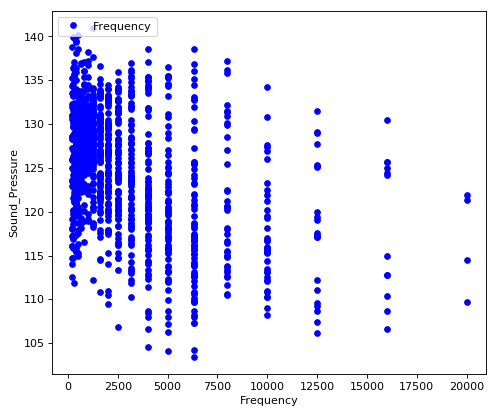

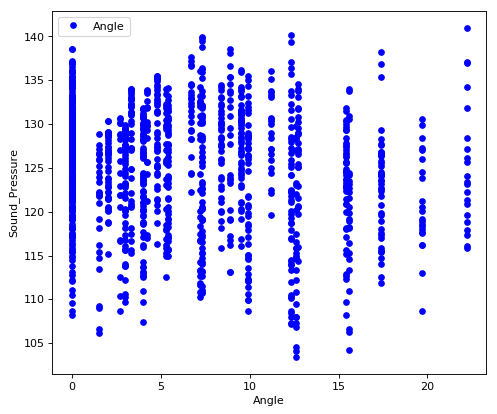

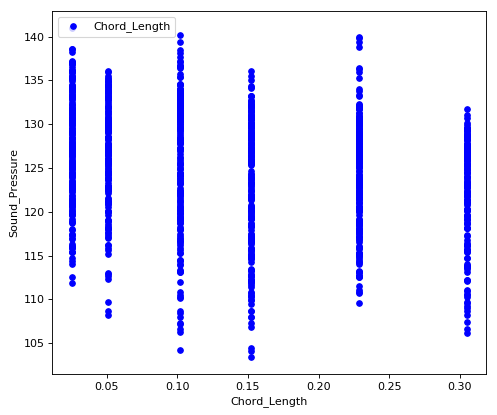

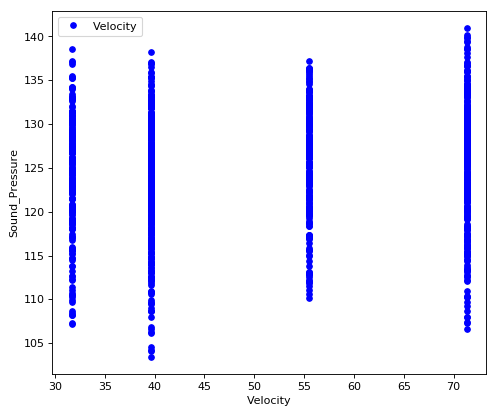

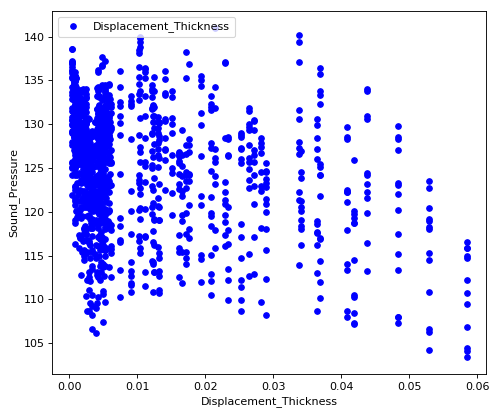

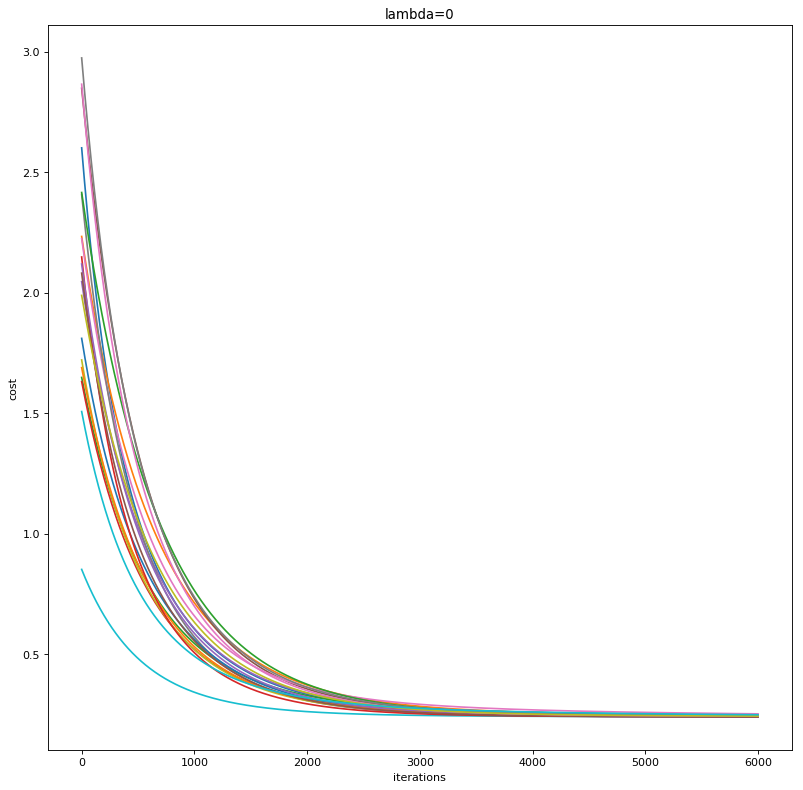

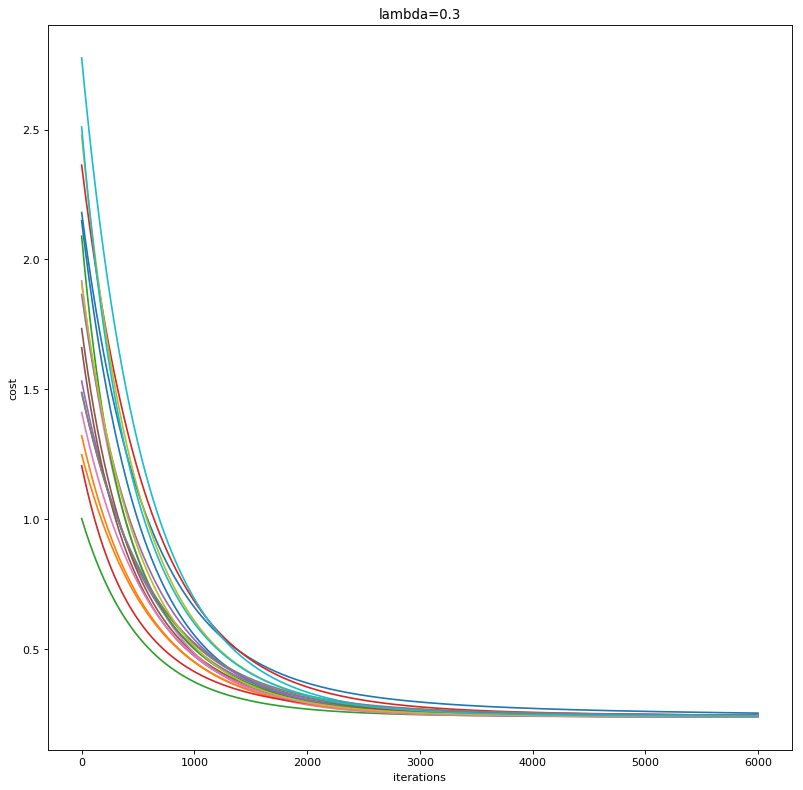

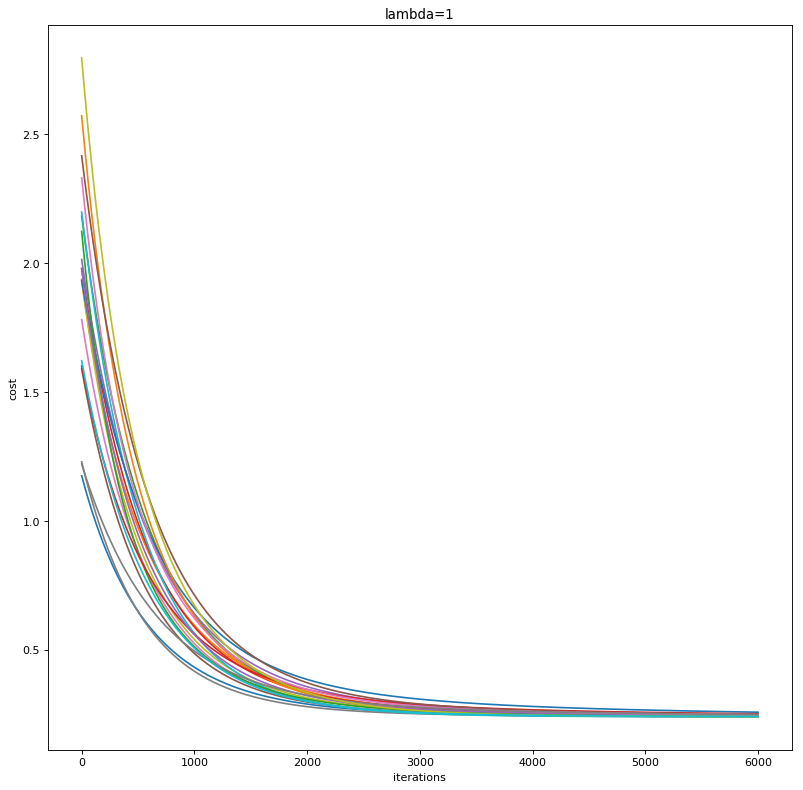

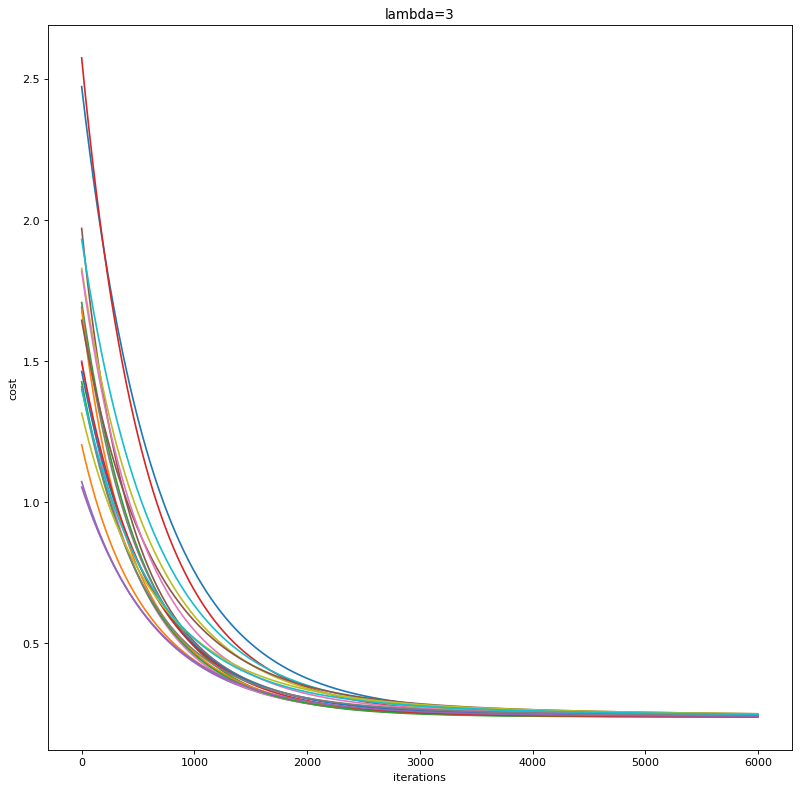

In [6]:
airfoil_csv = './Datasets/Question-3/airfoil.csv'
model3 = AirFoil(show_plots=True)
model3.train(train_csv=airfoil_csv, alpha=0.001, iterations=6000, possible_lambdas=[0, 0.3, 1, 3])
test_csv = './Datasets/Question-3/test.csv'
y_test = model3.predict(test_csv)

### When 0-0.5% of values are missing of that feature
We can drop those rows with missing values as the missing percentage is very less.

## When 8-10% of values are missing of that feature
Replace the missing value with mean or mode of the feature

## When 60-70% of values are missing of that feature
Since there are many missing values, any missing value replacement technique cannot be used. Remove the feature from the input
features and consider that available features for prediction